In [464]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage import img_as_uint

In [466]:
def plt_full_img(source_im,target_im):
    #vstupné obrázky na šedotónové
    img0,img1 = rgb2gray(plt.imread(source_im)),rgb2gray(plt.imread(target_im))

    #plot vstupného obrázka a jeho histogramu
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.imshow(img0, cmap='gray')
    plt.title("Vstupný obrázok")
    plt.subplot(1,2,2)
    plt.hist(np.reshape(img0,(img0.shape[0]*img0.shape[1],)), bins=20, histtype='bar', color='blue')
    plt.title("Vstupný obrázok - histogram")
    
    #plot cieľového obrázka a jeho histogramu
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.imshow(img1, cmap='gray')
    plt.title("Cieľový obrázok")
    plt.subplot(1,2,2)
    plt.hist(np.reshape(img1,(img1.shape[0]*img1.shape[1],)), bins=20, histtype='bar', color='red')
    plt.title("Cieľový obrázok - histogram")

In [490]:
def plt_hashtag_img(img00,img11,intrp_hist):
    #plot pre vyrezane obrazky
    plt.figure(figsize=(15,5))
    plt.subplot(131)
    plt.imshow(img00, cmap='gray')
    plt.title("Vstupný obrázok")
    plt.subplot(132)
    plt.imshow(img11, cmap='gray')
    plt.title("Cieľový obrázok")
    plt.subplot(133)
    plt.imshow(intrp_hist, cmap='gray')
    plt.title("Upravený vstupný obrázok prostredníctvom cieľového histogramu")
    
    #plot pre vyrezane obrázky - histogram
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.hist(np.reshape(img00,(img00.shape[0]*img00.shape[1],)), bins=12, histtype='bar', color='red')
    plt.title("Vstupný interpolovaný histogram")
    plt.subplot(1,3,2)
    plt.hist(np.reshape(img11,(img11.shape[0]*img11.shape[1],)), bins=12, histtype='bar', color='green')
    plt.title("Cieľový interpolovaný histogram")
    plt.subplot(1,3,3)
    plt.hist(np.reshape(intrp_hist,(intrp_hist.shape[0]*intrp_hist.shape[1],)), bins=12, histtype='bar', color='blue')
    plt.title("Upraveným histogramom pre cieľový obrázok")
    
    

In [518]:
def tile_hist(image0, image1):
    # vrati jedmorozmerne pole
    img0_rvl,img1_rvl = image0.ravel(),image1.ravel()
    
    # Ziskanie unikatnych hodnot pixelov cez unique
    img0_rvl_unq, img0_rvl_indx, img0_rvl_count = np.unique(img0_rvl, return_inverse=True, return_counts=True)
    img1_rvl_unq, img1_rvl_count = np.unique(img1_rvl, return_counts=True)

    # Normalizacia do rozsahu 0-1
    img0_norm = np.cumsum(img0_rvl_count).astype(np.uint)/np.cumsum(img0_rvl_count).astype(np.uint)[-1]
    img1_norm = np.cumsum(img1_rvl_count).astype(np.uint)/np.cumsum(img1_rvl_count).astype(np.uint)[-1]

    # Interpolacia 
    interpol = np.uint8(np.interp(img0_norm, img1_norm, img1_rvl_unq)[img0_rvl_indx].reshape(image0.shape))
      
    return interpol

In [523]:
def adap_hist_matching(source_im,target_im,D):
    #vstupné obrázky na šedotónové
    img0,img1 = rgb2gray(plt.imread(source_im)),rgb2gray(plt.imread(target_im))
      
    #prevod na 8bit -> celé kladné čísla
    src_img,trg_img = np.uint8(img_as_uint(img0)),np.uint8(img_as_uint(img1))

    #ošetrenie pre výrez resp. parameter D
    if D<=1 or D>img0.shape[0] or D>img0.shape[1]:
        return
    
    #delenie modulo pre zysok obrazku0 - modulo
    [he_R, we_R] = src_img.shape
    h_RF = he_R - (he_R % D)
    w_RF = we_R - (we_R % D)
    h_R_modl = he_R % D

    #prevod obrazku1
    [hIA, wIA] = trg_img.shape
    x_ova = int((D / we_R * 100) * (wIA / 100))
    y_ova = int((D / he_R * 100) * (hIA / 100))

    imout, temp, mc, tmpmc = src_img[0:D, 0:D], src_img[0:D, 0:D], True, True
    np.delete(imout, 1)
    np.delete(temp, 1)
    im1i, im1j, ilast = 0, 0, 0

    #cyklus pre h
    for i in range(0, h_RF, D):
        im1j=0
        for j  in range(0, w_RF, D):
            img00 = src_img[i:i+D, j:j+D]
            img11 = trg_img[im1i:im1i+y_ova, im1j:im1j+x_ova]
            intrp_hist = tile_hist(img00, img11)
            
            #vyplotovanie mriezky img aj hist
            #plt_hashtag_img(img00,img11,intrp_hist)

            if tmpmc:
                temp = intrp_hist
                tmpmc = False
            else:
                temp =  np.concatenate((temp, intrp_hist), axis=1)
            im1j += x_ova

        if mc:
            imout = temp
            mc = False
        else:
            imout = np.concatenate((imout, temp), axis=0)
        temp = src_img[0:D, 0:D]
        np.delete(temp, 1)
        tmpmc = True
        ilast = i
        im1i += y_ova

    ilast += D
    im1j = 0

    #cyklus pre w
    for i in range(0, w_RF, D):
        img0 = src_img[ilast:ilast + h_R_modl, i:i+D]
        img1 = trg_img[im1i:im1i + h_R_modl, im1j:im1j+x_ova]

        intrp_hist = tile_hist(img0, img1)

        if tmpmc:
            temp = intrp_hist
            tmpmc = False
        else:
            temp =  np.concatenate((temp, intrp_hist), axis=1)
        im1j += x_ova

    if mc:
        out_im = temp
    else:
        out_im = np.concatenate((imout, temp), axis=0)
    temp = src_img[0:D, 0:D]
    np.delete(temp, 1)

    return out_im

c:\users\user\anaconda3\envs\computer_vision_2\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\user\anaconda3\envs\computer_vision_2\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'Upravený obrázok - histogram')

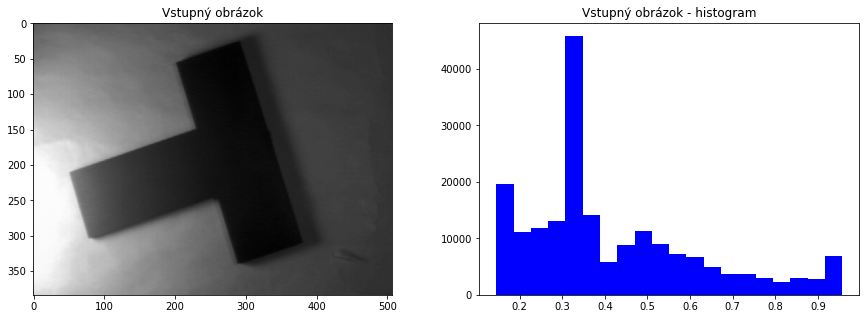

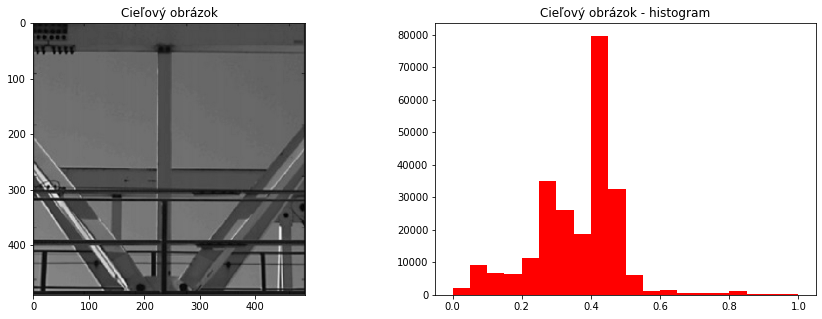

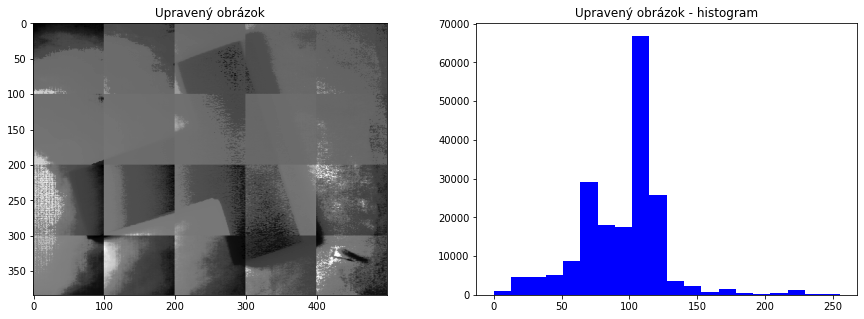

In [525]:
#zdrojové obrázky
source_im,target_im=("C:../imgs/tshape.png", "C:../imgs/most.png")

#úprava jasu pre cieľový obrázok 
out_im = adap_hist_matching(source_im,target_im, 100)

#plotovanie pôvodných obrázkov a ich histogramov
plt_full_img(source_im,target_im)

#plotovanie upraveného obrázku s jeho histogramom
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(out_im, cmap='gray')
plt.title("Upravený obrázok")
plt.subplot(1,2,2)
plt.hist(np.reshape(out_im,(out_im.shape[0]*out_im.shape[1],)), bins=20, histtype='bar', color='blue')
plt.title("Upravený obrázok - histogram")
